In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from scipy.linalg import pinv
from PIL import Image
from tensorflow.keras.models import Model
import joblib
import numpy as np
import os
from numpy.linalg import pinv
import matplotlib.pyplot as plt

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install medmnist
from medmnist import OrganAMNIST, TissueMNIST, BreastMNIST, DermaMNIST, FractureMNIST3D

# Downloading the validation split of OrganAMNIST
#dataset = OrganAMNIST(split="val", download=True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=f5172483f11219effaf2add0fb155ee0f523e9083032eae6ede943f320033dab
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [4]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from medmnist import OrganAMNIST, TissueMNIST, BreastMNIST, DermaMNIST, OCTMNIST

def load_data(dataset_class, split, num_images):
    dataset = dataset_class(split=split, download=True)
    images, labels = [], []
    dataset_indices = list(range(len(dataset)))
    random.shuffle(dataset_indices)

    for i in range(min(num_images, len(dataset))):
        img, label = dataset[dataset_indices[i]]
        if hasattr(img, 'numpy'):
            img = img.numpy()
        elif isinstance(img, Image.Image):
            img = np.array(img)
        else:
            continue

        images.append(img)
        labels.append(label)
    return images, labels


100%|██████████| 38247903/38247903 [00:00<00:00, 67764024.79it/s]


100%|██████████| 124962739/124962739 [00:01<00:00, 122751987.85it/s]


100%|██████████| 559580/559580 [00:00<00:00, 5325873.71it/s]


100%|██████████| 19725078/19725078 [00:00<00:00, 80384617.34it/s]


100%|██████████| 54938180/54938180 [00:00<00:00, 111746445.36it/s]


Total images in combined dataset: 878
OrganAMNIST: 200 images
TissueMNIST: 200 images
BreastMNIST: 78 images
DermaMNIST: 200 images
OCTMNIST: 200 images


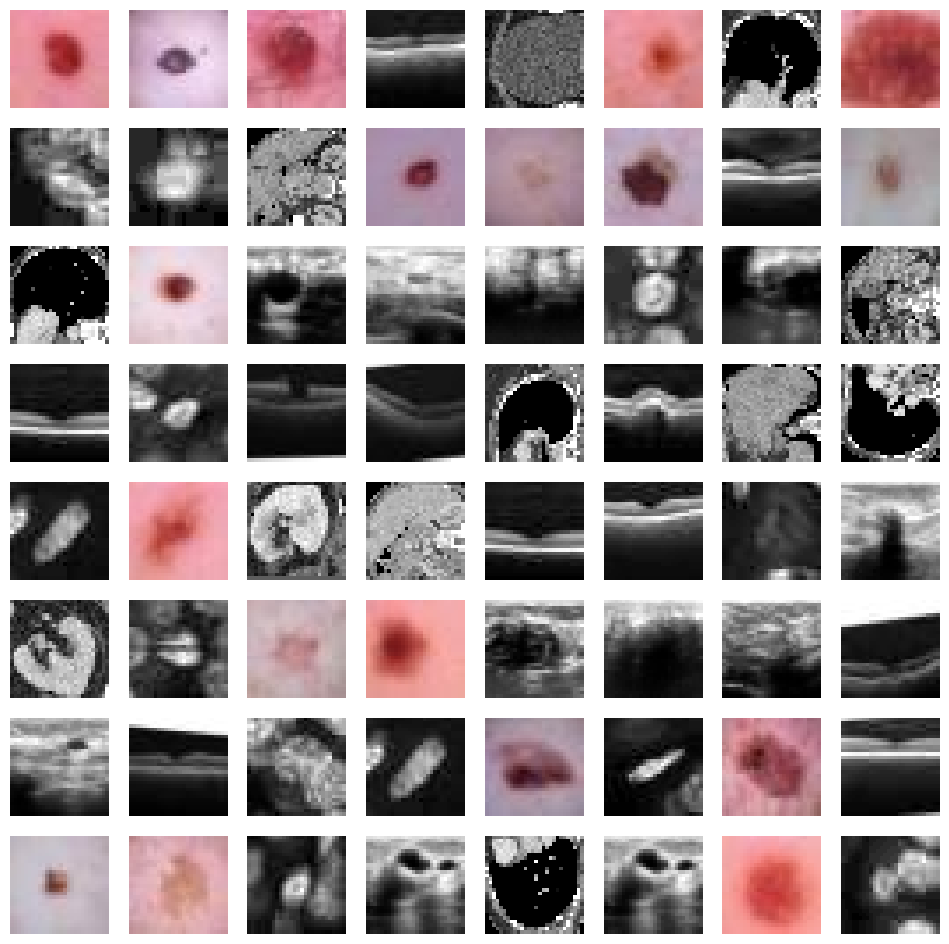

In [5]:
os.makedirs("combined_dataset", exist_ok=True)

datasets = [OrganAMNIST, TissueMNIST, BreastMNIST, DermaMNIST, OCTMNIST]
dataset_names = ['OrganAMNIST', 'TissueMNIST', 'BreastMNIST', 'DermaMNIST', 'OCTMNIST']
num_images = 200
total_images = 0
images_per_dataset = {}

for dataset_class, dataset_name in zip(datasets, dataset_names):
    images, labels = load_data(dataset_class, 'val', num_images)
    images_per_dataset[dataset_name] = len(images)
    total_images += len(images)

    for i, img_array in enumerate(images):
        if img_array.ndim == 3 and img_array.shape[0] == 1:
            img_array = img_array.squeeze(0)
        img = Image.fromarray(img_array)
        filename = os.path.join("combined_dataset", f"{dataset_name}_{i}.png")
        img.save(filename)

# Display the number of images
print(f"Total images in combined dataset: {total_images}")
for dataset_name, count in images_per_dataset.items():
    print(f"{dataset_name}: {count} images")

# Filter out datasets with no images
non_empty_datasets = {k: v for k, v in images_per_dataset.items() if v > 0}

# Display an 8x8 grid of images
plt.figure(figsize=(12, 12))
for i in range(64):
    if non_empty_datasets:
        rand_dataset = random.choice(list(non_empty_datasets.keys()))
        rand_index = random.randint(0, non_empty_datasets[rand_dataset] - 1)
        img_path = os.path.join("combined_dataset", f"{rand_dataset}_{rand_index}.png")
        img = Image.open(img_path)
        plt.subplot(8, 8, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    else:
        print("No images available to display.")
        break

plt.show()

In [6]:
import os
from PIL import Image
import numpy as np


num_images = 200  # or however many images you want to process

# Create directories
combined_dataset_dir = "/content/drive/My Drive/combined_dataset"
out_dist_cxr_dir = "/content/drive/My Drive/out-dist-cxr"
os.makedirs(combined_dataset_dir, exist_ok=True)
os.makedirs(out_dist_cxr_dir, exist_ok=True)

for dataset_class, dataset_name in zip(datasets, dataset_names):
    images, labels = load_data(dataset_class, 'val', num_images)

    for i, img_array in enumerate(images):
        if img_array.ndim == 3 and img_array.shape[0] == 1:
            img_array = img_array.squeeze(0)

        img = Image.fromarray(img_array)

        # Convert to grayscale and resize
        img_gray = img.convert("L")
        img_resized = img_gray.resize((224, 224))

        # Save the processed image
        filename = os.path.join(out_dist_cxr_dir, f"{dataset_name}_{i}.png")
        img_resized.save(filename)
        print(f"Saved image: {filename}")  # Debugging print

print("Processing complete.")


Using downloaded and verified file: /root/.medmnist/organamnist.npz
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_0.png
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_1.png
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_2.png
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_3.png
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_4.png
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_5.png
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_6.png
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_7.png
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_8.png
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_9.png
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_10.png
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_11.png
Saved image: /content/drive/My Drive/out-dist-cxr/OrganAMNIST_12.png
Saved image: /content/drive/My Drive/out-dist

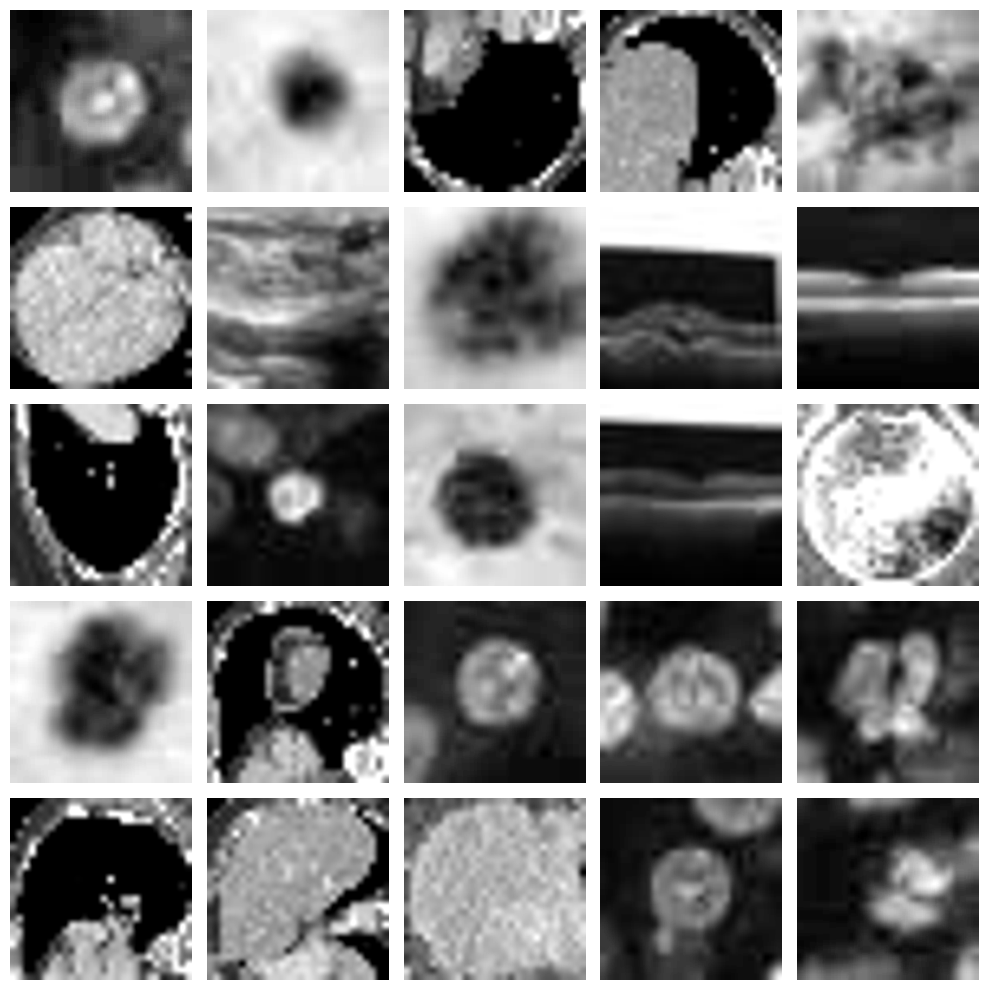

In [7]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

# Assuming that your images are in the 'out-dist-cxr' directory
image_folder = "/content/drive/My Drive/out-dist-cxr"

# Get all file names from the directory
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')]

# Randomly select 25 images if there are more than 25
if len(image_files) > 25:
    image_files = random.sample(image_files, 25)

# Create a 5x5 grid for displaying images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Set each subplot
for ax, image_file in zip(axes.flatten(), image_files):
    img = Image.open(image_file)
    ax.imshow(img, cmap='gray')
    ax.axis('off')  # Hide the axes ticks

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [8]:
import os
from collections import Counter

# Assuming that your images are in the 'out-dist-cxr' directory
image_folder = "/content/drive/My Drive/out-dist-cxr"

# Get all file names from the directory
image_files = [file for file in os.listdir(image_folder) if file.endswith('.png')]

# Extract dataset names from file names
dataset_names = [file.split('_')[0] for file in image_files]

# Count the frequency of each dataset name in the filenames
dataset_image_counts = Counter(dataset_names)

# It's easy to play with this, and change it to several other modalities
print(dataset_image_counts)


Counter({'TissueMNIST': 200, 'DermaMNIST': 200, 'OCTMNIST': 200, 'OrganAMNIST': 200, 'BreastMNIST': 78})


In [9]:
import os
from pathlib import Path

# Define directories
in_dist_dir = '/content/drive/My Drive/in_dist_pool'
os.makedirs(in_dist_dir, exist_ok=True)

# Use pathlib.Path to list all image files in the directory
cxr_image_count = len(list(Path(in_dist_dir).glob('*.png')))

print(cxr_image_count)


1000


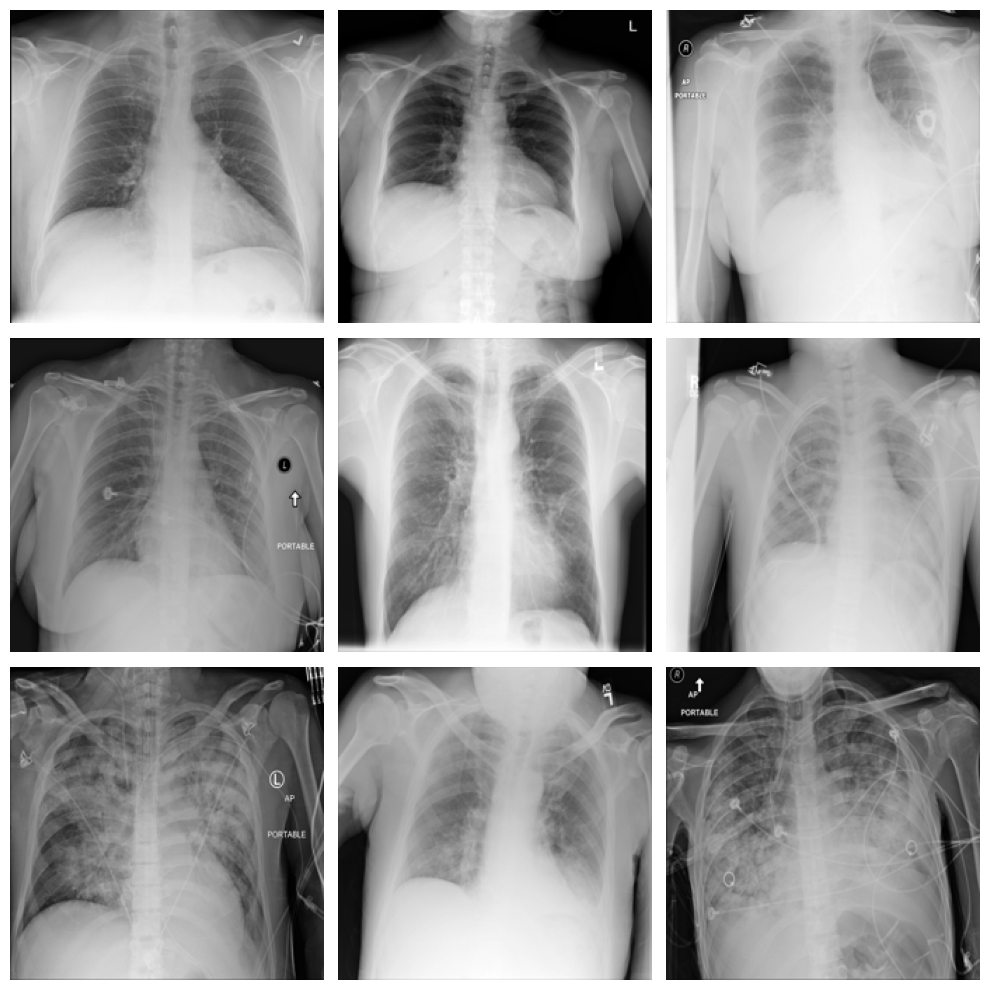

In [10]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Define the directory where the images are stored
in_dist_dir = '/content/drive/My Drive/in_dist_pool'

# Get the list of all image files in the directory
image_files = list(Path(in_dist_dir).glob('*.png'))  # Update the extension if different

# Select a subset of images at random to display
num_images_to_display = 9  # For a 3x3 grid of images
selected_image_files = random.sample(image_files, num_images_to_display)

# Create a grid for displaying the images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Adjust subplot dimensions as needed

# Plot each of the selected images
for ax, image_file in zip(axes.flatten(), selected_image_files):
    img = Image.open(image_file)
    ax.imshow(img, cmap='gray')  # Assume the images are grayscale
    ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()
